In [31]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
data = pd.read_csv('heart_cleaned.csv')

In [33]:
X = data.drop(['HeartDisease'], axis=1).values  
y = data['HeartDisease'].values

In [34]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [37]:
class HeartDiseasePredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_units=32, dropout_rate=0.3):
        super(HeartDiseasePredictionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [38]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        all_train_preds = []
        all_train_targets = []

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = (outputs > 0.5).float()
            all_train_preds.extend(preds.cpu().numpy())
            all_train_targets.extend(targets.cpu().numpy())
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        train_precision = precision_score(all_train_targets, all_train_preds)
        train_precisions.append(train_precision)
        train_recall = recall_score(all_train_targets, all_train_preds)
        train_recalls.append(train_recall)
        train_f1 = f1_score(all_train_targets, all_train_preds)
        train_f1s.append(train_f1)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        all_val_preds = []
        all_val_targets = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                all_val_preds.extend(preds.cpu().numpy())
                all_val_targets.extend(targets.cpu().numpy())
                correct_val += (preds == targets).sum().item()
                total_val += targets.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        val_precision = precision_score(all_val_targets, all_val_preds)
        val_precisions.append(val_precision)
        val_recall = recall_score(all_val_targets, all_val_preds)
        val_recalls.append(val_recall)
        val_f1 = f1_score(all_val_targets, all_val_preds)
        val_f1s.append(val_f1)

        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, "
              f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

    return (train_losses, val_losses, train_accuracies, val_accuracies,
            train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s)


In [39]:
input_dim = X_train.shape[1]
model = HeartDiseasePredictionModel(input_dim=input_dim, hidden_units=32, dropout_rate=0.3)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [41]:
metrics = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=300)


Epoch [1/300] - Train Loss: 0.6653, Val Loss: 0.6394, Train Acc: 0.6499, Val Acc: 0.7826, Train F1: 0.6003, Val F1: 0.7872
Epoch [2/300] - Train Loss: 0.6025, Val Loss: 0.5681, Train Acc: 0.8038, Val Acc: 0.8261, Train F1: 0.8159, Val F1: 0.8384
Epoch [3/300] - Train Loss: 0.5151, Val Loss: 0.4787, Train Acc: 0.8324, Val Acc: 0.8370, Train F1: 0.8449, Val F1: 0.8515
Epoch [4/300] - Train Loss: 0.4378, Val Loss: 0.4138, Train Acc: 0.8460, Val Acc: 0.8370, Train F1: 0.8593, Val F1: 0.8529
Epoch [5/300] - Train Loss: 0.3903, Val Loss: 0.3887, Train Acc: 0.8447, Val Acc: 0.8424, Train F1: 0.8568, Val F1: 0.8571
Epoch [6/300] - Train Loss: 0.3733, Val Loss: 0.3835, Train Acc: 0.8542, Val Acc: 0.8424, Train F1: 0.8674, Val F1: 0.8571
Epoch [7/300] - Train Loss: 0.3620, Val Loss: 0.3773, Train Acc: 0.8501, Val Acc: 0.8478, Train F1: 0.8632, Val F1: 0.8627
Epoch [8/300] - Train Loss: 0.3642, Val Loss: 0.3723, Train Acc: 0.8488, Val Acc: 0.8478, Train F1: 0.8614, Val F1: 0.8627
Epoch [9/300] - 

In [42]:
# 解包训练和验证指标
(train_losses, val_losses, train_accuracies, val_accuracies,
 train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s) = metrics


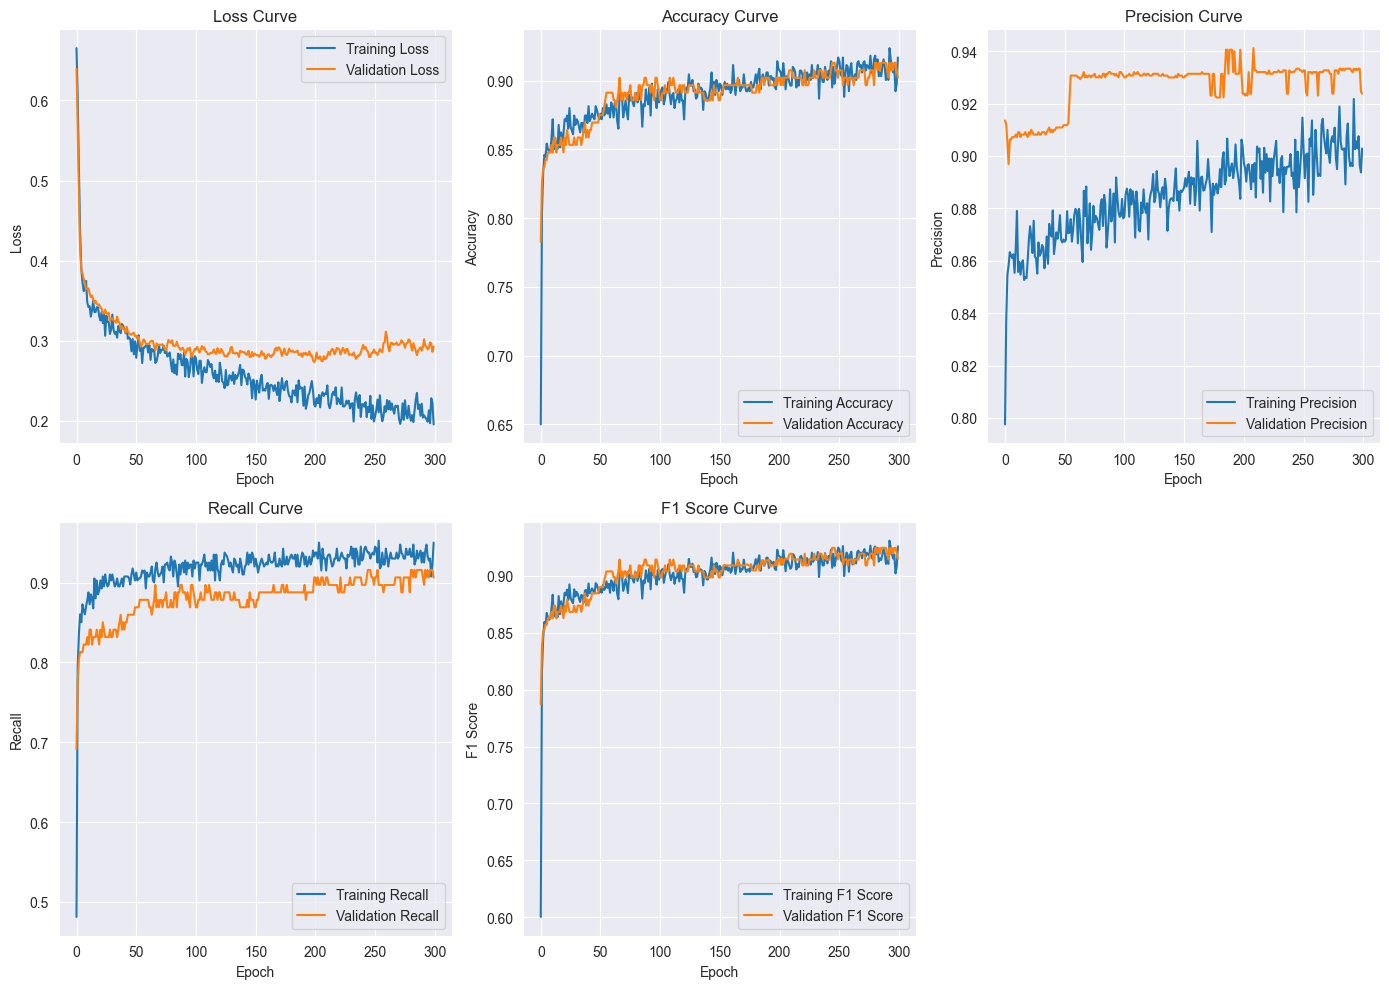

In [43]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_precisions, label='Training Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_recalls, label='Training Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_f1s, label='Training F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()

plt.tight_layout()
plt.show()

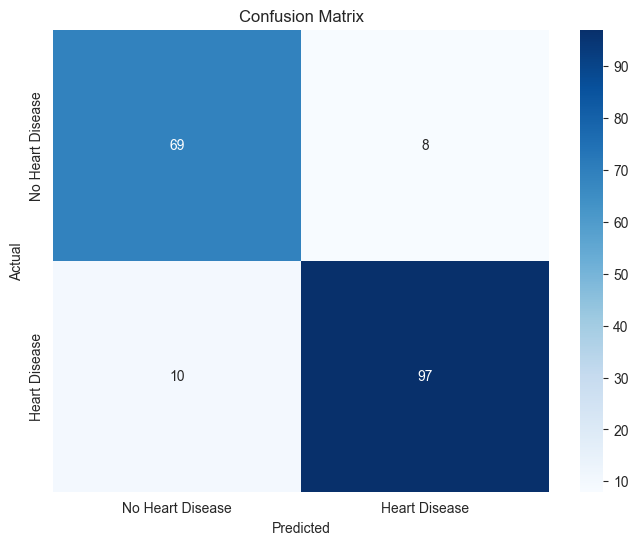

In [44]:
y_val_true = y_val.cpu().numpy()
y_val_pred = (model(X_val) > 0.5).float().cpu().numpy()

conf_matrix = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()